# UMAP
## A Functional Introduction

### Uniform Manifold Approximation and Projection (UMAP) 
is a dimension reduction
technique that can be used for visualisation similarly to t-SNE, but also for
general non-linear dimension reduction. The algorithm is founded on three
assumptions about the data

1. The data is uniformly distributed on Riemannian manifold;
2. The Riemannian metric is locally constant (or can be approximated as such);
3. The manifold is locally connected (not globally, but locally).

From these assumptions it is possible to model the manifold with a fuzzy
topological structure. The embedding is found by searching for a low dimensional
projection of the data that has the closest possible equivalent fuzzy
topological structure.




### A Simple Task
Lets just run umap on a common dataset, using the UMAP defaults

In [1]:
# Grab what we need via imports
from sklearn.datasets import load_digits
import numpy as np

# DR methodsfrom IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')
import umap
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA, KernelPCA

# Visualizations
import matplotlib.pyplot as plt
%matplotlib nbagg
# Bokeh imports
import bokeh.plotting as bk
bk.output_notebook()
from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool, ColumnDataSource
output_notebook()


# Load in the digit dataset, and take a look at its shape
digits = load_digits()
labels = digits.target



Loading BokehJS ...

Loading BokehJS ...

### UMAP it!

In [5]:
# This is the embedding
%time embedding = umap.UMAP(n_components=2).fit_transform(digits.data)

CPU times: user 2.1 s, sys: 492 ms, total: 2.59 s
Wall time: 2.01 s


In [6]:
# Here lets compare the original shape to the embedding
print("Original Data Shape: ", digits.data.shape)
print("Embedded Data Shape: ", embedding.shape)

('Original Data Shape: ', (1797, 64))
('Embedded Data Shape: ', (1797, 2))


That's all well and good, but I want to see what the embedding looks like. 
Let's make a simple plot

<IPython.core.display.Javascript object>


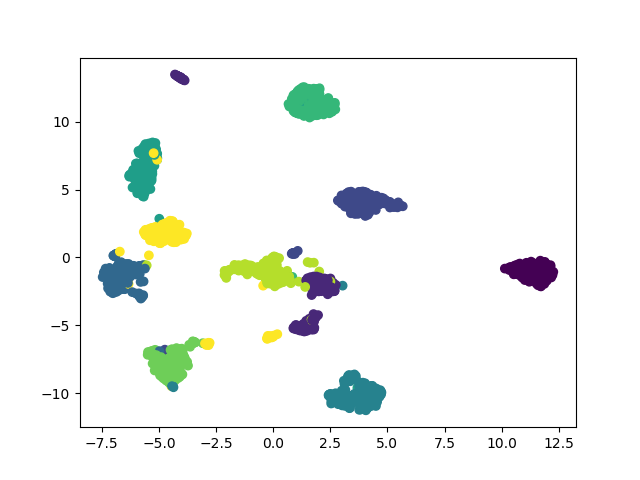

In [7]:
plt.scatter(embedding[:,0], embedding[:,1], c=digits.target)
plt.show()

This is colored according to the target number, and then mapped to rbg by matplotlib. This is also all well and good, but I want to be able to interrogate the plot a bit more thoroughly. For this I'm going to use bokeh. 
In the next plot, you'll be able to zoom in and out, and mouse over the scatter plot points. There'll be a hover window that appears and shows you the number source, and shows you the target number next to the image (on the left and right hand side of the hovertool respectively)

First I need to create the images from digits.data, then save them so bokeh can load the image

In [38]:
# Right there's almost certainly a better way to do this, but I can't think of it, 
#  or find the code online.

#  So I'm going to bodge it

'''
This block of code builds a .png for each digit, and saves it in the folder 'imgs/'
This lets the bokeh plot call up the image and display it in the graph, letting us
  inspect the quality of various dimension reductions. 
'''
from PIL import Image
import PIL

# BODGE
import os
imgSource = []
urlSource = []

if not os.path.isfile('imgs/0.png'):
    for i in range(len(digits.data)):
        if not os.path.exists('imgs'):
            os.makedirs('imgs')
        x = digits.data[i].reshape((8, 8)) # sklearn digits are 8X8: adjust for other digits
        im = Image.new('L', (len(x[0]), len(x)))  # type, size
        im.putdata([int(255-p*255) for row in x for p in row])
        im.save("imgs/"+str(i)+".png")
        imgSource.append( "imgs/"+str(i)+".png")
    
else:
    for i in range(len(digits.data)):
        # This order assumes the digits aren't reordered or relabeled,
        #   It's an invalid assumption, but as long as the user doesn't
        #   go snooping around, it should hold true
        imgSource.append( "imgs/"+str(i)+".png")
        urlSource.append("https://raw.githubusercontent.com/CrakeNotSnowman/umapNotebooks/master/imgs/"+str(i)+".png")
imgSource = urlSource

# Warnings bodge
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

Now that the ugly bodge is dealt with, we can focus on the plotting

This block of code will take in the lower d points, take in a set of labels, a list of files to the source images, and an optional title. It returns a bokeh figure which can be displayed elsewhere in code.

Hovering over any point in the plot will show the hovertool, which should display the digit image on the left, and the number it's classifed as on the right

In [29]:
def makePlot(embedding, labels, imgs, title='', h=None, w=None):
    def mapNumToC(c):
        # Maps a function (labels) to colors
        mini = float(min(c))
        maxi = float(max(c))
        colors = []
        for i in c:
            i = float(i)
            ratio = 2. * (i - mini) / (maxi-mini)
            b = int(max(0, 255*(1 - ratio)))
            r = int(max(0, 255*(ratio - 1)))
            g = 255 - b - r
            colors.append('#%02x%02x%02x' % (r,g,b))
        return colors

    c = mapNumToC(labels)

    source = ColumnDataSource(data=dict(
        x=embedding[:,0],
        y=embedding[:,1],
        value=labels,
        fill_color=c,
        imgs=imgs
    ))

    hover = HoverTool(
        tooltips="""
        <div>
            <div>
                <img
                    src="@imgs" height="16" alt="@imgs" width="16"
                    style="float: left; margin: 0px 15px 15px 0px;"
                    border="2"
                ></img>
                
                <span style="float: right;font-size: 16px; font-weight: bold;">@value</span>
            </div>
        </div>
        """
    )
    
    if (type(h) == int) and (type(w) == int):
        p = figure(tools=[hover, 'reset,wheel_zoom,undo,redo,save,tap,pan'],
               title=title, plot_width=w, plot_height=h)
    else:
        p = figure(tools=[hover, 'reset,wheel_zoom,undo,redo,save,tap,pan'],
               title=title)
        
    p.circle('x', 'y', size=8, source=source, line_color=None, fill_color=c,)
    
    return p

In [39]:

p = makePlot(embedding, labels, imgSource)
t = show(p)

/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


### Take some time to explore this plot
Without looking at the specific points, you can see that UMAP does a really good job for the most part. And mousing over the points that look like they're in the wrong cluster, you can see that those numbers actually look like their neighbors. But lets get a bit of persepective 

For that, we're going to compare UMAP with the classic PCA (by way of singular value decomposition) and to the currently very popular t-SNE.

### First taking a look at PCA 
Being a linear method, it's very fast

However if the data is the result of some non linear function, it fails to useful capture the information in just two dimensions.  

In [40]:
%time pca_Embedding = PCA(n_components=2).fit_transform(digits.data)

CPU times: user 20 ms, sys: 60 ms, total: 80 ms
Wall time: 18.1 ms


In [41]:
pca_p = makePlot(pca_Embedding, labels, imgSource)
pca_t = show(pca_p)

/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


### Next we'll examine t-SNE
It's currently being used becuase it's very fast for a non linear dimensionaly reduction algorithm, and it scales much better than what was previously the state of the art when data increases in amount, and dimensionality. This is in part thanks to the barnes-hut approximation


In [42]:
%time tsne_Embedding = manifold.TSNE(n_components=2).fit_transform(digits.data)

CPU times: user 16.3 s, sys: 1.09 s, total: 17.4 s
Wall time: 17.4 s


In [43]:
tsne_p = makePlot(tsne_Embedding, labels, imgSource)
tsne_t = show(tsne_p)

/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


### Comparing the plots
We can see that singular value decomposition is not particularly useful in the data visualization. The first two principle componets don't have enough information to show the sepperation between numbers that you see with UMAP and t-SNE
UMAP and t-SNE reduce the dimensions while preserving the distance between distince clusters of numbers. Looking at both t-SNE and UMAP, we can see there are some points which have been mapped near different numbers. 

Mousing over we can see why, 'digits' isn't the cleanest data, and the numbers honestly look similar to the numbers they're clustered around. Some people just have bad handwritting. 

In [44]:

from bokeh.layouts import gridplot
grid = gridplot([[makePlot(embedding, labels, imgSource,title="UMAP", h=480, w=480), \
                  makePlot(tsne_Embedding, labels, imgSource,title="TSNE", h=480, w=480)
                  
                 ], 
                 [makePlot(pca_Embedding, labels, imgSource, title="PCA", h=480, w=480),
                  None
                 ]])

# show the results
show(grid)

/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)


## Getting more control
UMAP offers a number of parameters. So far we've just viewed the impact of the defaults, but there are many other options we could use. Below is a list of the input parameters availble. We'll explore some of these in more depth than others in this notebook.

    n_neighbors: float (optional, default 15)
    n_components: int (optional, default 2)
    metric: string or function (optional, default 'euclidean')
    gamma: float (optional, default 1.0)
    n_edge_samples: int (optional, default None)
    alpha: float (optional, default 1.0)
    init: string (optional, default 'spectral')
    min_dist: float (optional, default 0.1)
    spread: float (optional, default 1.0)
    a: float (optional, default None)
    b: float (optional, default None)
    random_state: int, RandomState instance or None, optional (default: None)
    metric_kwds: dict (optional, default {})
    verbose: bool (optional, default False)
    
I'll be going a bit out of order here, so the early points examine the more useful parameters and their impact, then we'll take a look at more obscure parameters
    
    
### `n_neighbors`

    The size of local neighborhood (in terms of number of neighboring
    sample points) used for manifold approximation. Larger values
    result in more global views of the manifold, while smaller
    values result in more local data being preserved. In general
    values should be in the range 2 to 100.
        
Lets first take a look at `n_neighbors`. Most manifold learning techniques are built on the idea that a significant amount of high dimensional data sits on a 'surface', and that the surface has been contorted. The specific contorisons are unknown, but there's an assumption that the distance on the 'non-contorted surface' more accurately represents the real, effective difference between high dimension points than the euclidean distance (or other metrics) when those metrics operate on the high dimension representation. 

There's a convient parellel between this assumption and your life: when you are traveling form one city to another city, you think of the distance as the distance between your location and your target as the distance over the surface of the earth. The further you travel (to a point--yay non-linearity) the greater the error between the distance of the path you take, and the distance of a straight line between your starting location and final location. 

Something something rather than checking in at radius r, you check your closest neighbor, and try to get to point b from then, then their close neighbors, etc until you arive at b

The greater n, the fewer steps between you and your target, the closer to linear DR you'll end up with

Another something something, let's start playing around

    

In [45]:
print len(digits.data)

1797


In [46]:
neighbor_Sizes = [2, 5, 10, 15, 20, 50, 100, 200, 500]
nSizeEmbeddings = []
for ns in neighbor_Sizes:
    print "n_neighbors: ", ns
    %time e = umap.UMAP(n_neighbors=ns).fit_transform(digits.data)
    nSizeEmbeddings.append(e)


n_neighbors:  2
CPU times: user 2.42 s, sys: 1.32 s, total: 3.74 s
Wall time: 2.01 s
n_neighbors:  5
CPU times: user 2.06 s, sys: 884 ms, total: 2.94 s
Wall time: 1.76 s
n_neighbors:  10
CPU times: user 2.03 s, sys: 632 ms, total: 2.66 s
Wall time: 1.85 s
n_neighbors:  15
CPU times: user 1.97 s, sys: 616 ms, total: 2.59 s
Wall time: 1.8 s
n_neighbors:  20
CPU times: user 2.12 s, sys: 520 ms, total: 2.64 s
Wall time: 1.94 s
n_neighbors:  50
CPU times: user 2.44 s, sys: 532 ms, total: 2.97 s
Wall time: 2.26 s
n_neighbors:  100
CPU times: user 2.8 s, sys: 560 ms, total: 3.36 s
Wall time: 2.69 s
n_neighbors:  200
CPU times: user 3.68 s, sys: 508 ms, total: 4.18 s
Wall time: 3.48 s
n_neighbors:  500
CPU times: user 5.69 s, sys: 1.22 s, total: 6.91 s
Wall time: 5.39 s


Notice the time increase as the number of neighbors increased

But lets take a look at how it performs

In [47]:
plotSets = []
w = 240
h = 240

for i in range(len(nSizeEmbeddings)):
    plotSets.append(makePlot(nSizeEmbeddings[i], labels, imgSource,\
                             title=str(neighbor_Sizes[i])+ ' neighbors', h=h, w=w))
    
while len(plotSets)%4 != 0:
    plotSets.append(None)
    
gridOfPlots = np.reshape(plotSets, (len(plotSets)/4, 4))

grid = gridplot(list(gridOfPlots))

# show the results
show(grid)

/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/home/keith/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterabl

#### I'll be honest, I don't understand what's going on with 500 neighbors
It looks almost as if there's an error and the data is duplicated, but if you zoom in on the lobes and search for embeddings of '9', you'll notice one lobe has far more than the other, meaning the data doesn't appear to be duplicated

That said, the visually 5 to 100 neighbors seems more appealing, and has the advantage of speed compared to higher neighbor counts